In [1]:
%%html
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="#" onClick="code_toggle();"><h3>Click here to hide/show the code</h3></a>

# A tour of point cloud processing
### Mathieu Carette
Slides / notebook available at https://github.com/rockestate/point-cloud-processing

# About me

- PhD in Mathematics (ULB, 2009)
- Postdocs (UIUC, UCLouvain, McGill)
- Data Scientist (KBC, Forespell)
- Now working on
<a href="https://www.rockestate.be">
    <img src="../img/rockestate-logo-notext.png" alt="Drawing" style="width: 120px;"/>
    <p style="text-align: center; font-size: xx-large;"><b>ROCKESTATE</b></p>
</a>

Favorite software stack:

<div class="imgContainer"><img src="../img/python-logo.png" alt="Python logo" style="width: 200px;"/></div>
<div class="imgContainer"><img src="../img/jupyter_logo.png" alt="Jupyter logo" style="width: 200px;"/></div>
<div class="imgContainer"><img src="../img/conda_logo.png" alt="Conda logo" style="width: 200px;"/></div>

# Where do 3D point clouds come from?

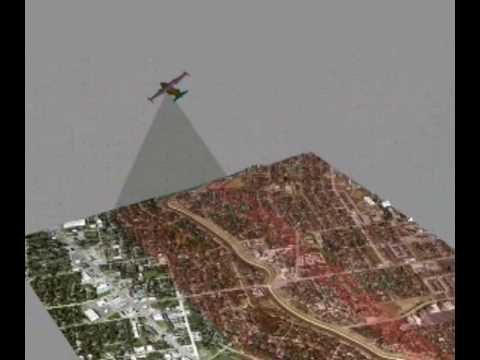

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('GSPcyhSAgTQ',start=7, end=31)

Open LiDAR data for Brussels and Flanders : https://remotesensing.agiv.be/opendata/lidar/

# File formats and software

- [LAS](https://www.asprs.org/committee-general/laser-las-file-format-exchange-activities.html) standard file format
- [LAZ](https://www.laszip.org/) compressed file format

<div class="imgContainer"><img src="../img/pcl_logo.png" alt="PCL logo" style="width: 200px;"/></div>
- [PCL](http://pointclouds.org/) **P**oint **C**loud **L**ibrary
  - Open source: https://github.com/PointCloudLibrary/pcl
  - C++
  - Powerful general purpose algorithms

<div class="imgContainer"><img src="../img/cgal_logo.png" alt="CGAL logo" style="width: 200px;"/></div>
- [CGAL](https://www.cgal.org/) **C**omputational **G**eometry **A**lgorithms **L**ibrary
  - Open source: https://github.com/CGAL/cgal
  - C++
  - State of the art 2D and 3D geometry algorithms

<div class="imgContainer"><img src="../img/pdal_logo.png" alt="PDAL logo" style="width: 200px;"/></div>
- [PDAL](https://www.pdal.io) **P**oint **D**ata **A**bstraction **L**ibrary
  - Open source: https://github.com/PDAL/PDAL
  - C++, command-line, python
  - Wraps some PCL functionality
  - For windows users: part of the [OSGeo4W](https://trac.osgeo.org/osgeo4w/) distribution

<div class="imgContainer"><img src="../img/lastools_logo.jpeg" alt="LAStools logo" style="width: 200px;"/></div>
- [LAStools](https://rapidlasso.com/lastools/) from RapidLasso
  - Proprietary, preferred pricing for academic use
  - Windows only, runs on wine
  - command-line, GUI
  - Open source [laszip](https://www.laszip.org) compression/decompression: https://github.com/LASzip/LASzip

# Let's process some point clouds

In [1]:
import glob
import io
import ipyleaflet
import IPython.display
import ipyvolume.pylab as p3
import json
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pdal
import PIL
import pyproj
import requests
import shapely.geometry
import scipy.spatial
import sys
import urllib
import pandas as pd
#import urllib.request

%load_ext autoreload
%autoreload 2
    
sys.path.append('../src')
from pcl_utils import local_max

# Url for aerial imagery
IVaerial = "https://geoservices.informatievlaanderen.be/raadpleegdiensten/ogw/wms?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&CRS=EPSG:31370&BBOX={0},{1},{2},{3}&WIDTH=512&HEIGHT=512&LAYERS=OGWRGB13_15VL&STYLES=default&FORMAT=image/png"

%matplotlib inline

In [2]:
# Download the LAS data file if not already present
if not os.path.isdir('../data'):
    os.makedirs('../data')
lidar_filename = 'LiDAR_DHMV_2_P4_ATL12431_ES_20140325_31195_2_150500_166500.las'
if not os.path.isfile('../data/' + lidar_filename):
    urllib.urlretrieve('https://s3-eu-west-1.amazonaws.com/rockestate-public/lidar/' + lidar_filename, 
                               '../data/' + lidar_filename)

In [4]:
m = ipyleaflet.Map(center=(50.81343, 4.38188), zoom=16)
dc = ipyleaflet.DrawControl()
m.add_control(dc)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[50.81343, 4.38188], controls=(DrawControl(layer=FeatureGroup(), polygon={'shapeOptions': {}}, polyline={'shapeOptions': {}}),), default_tiles=TileLayer(base=True, max_zoom=19, min_zoom=1, options=[u'attribution', u'tile_size', u'min_zoom', u'max_zoom', u'detect_retina']), layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=[u'attribution', u'tile_size', u'min_zoom', u'max_zoom', u'detect_retina']),), options=[u'keyboard_pan_offset', u'tap', u'attribution_control', u'max_zoom', u'min_zoom', u'bounce_at_zoom_limits', u'keyboard', u'scroll_wheel_zoom', u'dragging', u'inertia_max_speed', u'close_popup_on_click', u'zoom_control', u'box_zoom', u'double_click_zoom', u'tap_tolerance', u'zoom_start', u'keyboard_zoom_offset', u'inertia_deceleration', u'inertia', u'center', u'zoom', u'world_copy_jump', u'zoom_animation_threshold', u'touch_zoom', u'basemap'], zoom=16)

POLYGON ((150757.6490795802 166882.3036765475, 150874.0681703197 166935.1617697617, 150851.3651242579 166991.000159679, 150724.3778073959 166923.0123910382, 150757.6490795802 166882.3036765475))


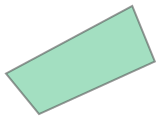

In [7]:
wsg84 = pyproj.Proj(init='epsg:4326')
lambert = pyproj.Proj(init='epsg:31370')
coords = [pyproj.transform(wsg84,lambert,x,y) for (x,y) in dc.last_draw['geometry']['coordinates'][0]]
polygon = shapely.geometry.Polygon(coords)
print(polygon.wkt)
IPython.display.display(polygon)

In [8]:
b = polygon.bounds
cropper = {
    "pipeline": [ '../data/'+ lidar_filename,
        {   "type":"filters.crop",
            'bounds':str(([b[0], b[2]],[b[1], b[3]]))},
        {   "type":"filters.crop",
            'polygon':polygon.wkt},
        {   "type":"filters.hag"},
        {   "type":"filters.eigenvalues",
            "knn":16},
        {   "type":"filters.normal",
            "knn":16}
    ]}
pipeline = pdal.Pipeline(json.dumps(cropper).decode('UTF-8'))
pipeline.validate()
%time n_points = pipeline.execute()
print('Pipeline selected {} points ({:.1f} pts/m2)'.format(n_points, n_points/polygon.area))

CPU times: user 1.34 s, sys: 69.1 ms, total: 1.4 s
Wall time: 2.27 s
Pipeline selected 40354 points (5.3 pts/m2)


In [9]:
b = polygon.bounds
cropper = {
    "pipeline": [ '../data/'+ lidar_filename,
        {   "type":"filters.crop",
            'bounds':str(([b[0], b[2]],[b[1], b[3]]))},
        {   "type":"filters.crop",
            'polygon':polygon.wkt},
        {   "type":"filters.hag"},
        {   "type":"filters.eigenvalues",
            "knn":16},
        {   "type":"filters.normal",
            "knn":16}
    ]}
json.dumps(cropper)



'{"pipeline": ["../data/LiDAR_DHMV_2_P4_ATL12431_ES_20140325_31195_2_150500_166500.las", {"type": "filters.crop", "bounds": "([150724.37780739594, 150874.06817031966], [166882.30367654748, 166991.00015967898])"}, {"type": "filters.crop", "polygon": "POLYGON ((150757.6490795802 166882.3036765475, 150874.0681703197 166935.1617697617, 150851.3651242579 166991.000159679, 150724.3778073959 166923.0123910382, 150757.6490795802 166882.3036765475))"}, {"type": "filters.hag"}, {"knn": 16, "type": "filters.eigenvalues"}, {"knn": 16, "type": "filters.normal"}]}'

In [11]:
# Load Pipeline output in python objects
arr = pipeline.arrays[0]
description = arr.dtype.descr
cols = [col for col, __ in description]
df = pd.DataFrame({col: arr[col] for col in cols})
df['X_0'] = df['X']
df['Y_0'] = df['Y']
df['Z_0'] = df['Z']
df['X'] = df['X'] - df['X_0'].min()
df['Y'] = df['Y'] - df['Y_0'].min()
df['Z'] = df['Z'] - df['Z_0'].min()

In [12]:
fig = p3.figure(width=1000)
fig.xlabel='Y'
fig.ylabel='Z'
fig.zlabel='X'
all_points = p3.scatter(df['Y'], df['Z'], df['X'], color='red', size=.2)
p3.squarelim()
p3.show()

VBox(children=(Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], scatters=[Scatter(color_selected=array('white', dtype='|S5'), size=array(0.2), size_selected=array(2.6), x=array([  0.  ,   0.  ,   0.53, ..., 108.01, 108.03, 108.01]), y=array([ 0.99,  1.08,  1.04, ..., 12.01, 11.95, 12.19]), z=array([ 33.49,  33.05,  34.33, ..., 127.02, 126.6 , 126.15]))], style={'box': {'visible': True}, 'axes': {'color': 'black', 'visible': True, 'ticklabel': {'color': 'black'}, 'label': {'color': 'black'}}, 'background-color': 'white'}, tf=None, width=1000, xlabel=u'Y', xlim=[-20.764999999999418, 128.79499999999825], ylabel=u'Z', ylim=[-59.849999999998836, 89.70999999999884], zlabel=u'X', zlim=[0.0, 149.55999999999767]),))

In [13]:
# Color ground in grey
df['ground'] = df['Classification']!=1
ground = p3.scatter(df.loc[df['ground'],'Y'], df.loc[df['ground'],'Z'], df.loc[df['ground'],'X'], color='red', size=.2)
non_ground = p3.scatter(df.loc[~df['ground'],'Y'], df.loc[~df['ground'],'Z'], df.loc[~df['ground'],'X'], color='red', size=.2)
fig.scatters.append(ground)
fig.scatters.append(non_ground)
all_points.visible = False
ground.color='lightgrey'

In [14]:
# Show ground as surface
ground_delaunay = scipy.spatial.Delaunay(df.loc[df['ground'],['X','Y']])
ground_surf = p3.plot_trisurf(df.loc[df['ground'],'Y'], df.loc[df['ground'],'Z'], df.loc[df['ground'],'X'], ground_delaunay.simplices, color='lightgrey')
fig.meshes.append(ground_surf)
ground.visible=False

In [15]:
# Color points according to flatness
df['flatness'] = df['Eigenvalue0'] 
non_ground.color=matplotlib.cm.viridis(df.loc[~df['ground'],'flatness']*4)[:,0:3]

In [19]:
# Separate between trees and the rest
df['tree_potential'] = (df['Classification']==1) & (df['HeightAboveGround'] >= 2) & (df['flatness'] > .05) &  (df['NumberOfReturns'] - df['ReturnNumber'] >= 1) 
df['other'] = ~df['ground'] & ~df['tree_potential']
tree_potential = p3.scatter(df.loc[df['tree_potential'],'Y'], df.loc[df['tree_potential'],'Z'], df.loc[df['tree_potential'],'X'], color=matplotlib.cm.viridis(df.loc[df['tree_potential'],'flatness']*4)[:,0:3], size=.2)
other = p3.scatter(df.loc[df['other'],'Y'], df.loc[df['other'],'Z'], df.loc[df['other'],'X'], color=matplotlib.cm.viridis(df.loc[df['other'],'flatness']*4)[:,0:3], size=.2)
non_ground.visible=False
tree_potential.color='darkgreen'
other.color='red'

In [20]:
#Hide non-tree
other.visible=False

In [21]:
lep = local_max(df.loc[df['tree_potential'],['X','Y','Z','HeightAboveGround']], radius=3, density_threshold=15)

In [22]:
treetop_spheres = p3.scatter(lep['Y'], lep['Z'], lep['X'], color='red', size=.5, marker='sphere')
fig.scatters.append(treetop_spheres)

In [23]:
treetop_spheres.color = matplotlib.cm.Vega10(np.arange(len(lep['Z']))%10)[:,0:3]

In [24]:
kdtree = scipy.spatial.kdtree.KDTree(lep[['X','Y','Z']])
dist, idx = kdtree.query(df.loc[df['tree_potential'],['X','Y','Z']].values)
tree_potential.color=matplotlib.cm.Vega10(idx%10)[:,0:3]
df.loc[df['tree_potential'], 'tree_idx'] = idx

In [25]:
medians = df.groupby('tree_idx')[['X','Y','Z']].median()
for axis in ['X','Y','Z']:
    df['d'+axis] = df[axis] - df['tree_idx'].map(medians[axis])
df['radius'] = np.linalg.norm(df[['dX', 'dY', 'dZ']].values, axis=1)
radii = pd.DataFrame([df.groupby('tree_idx')['radius'].quantile(.5), lep['HeightAboveGround'].values*.4]).min()

In [26]:
scale = max(df['X'].max() - df['X'].min(), df['Y'].max() - df['Y'].min())
treetop_spheres.x = medians['Y']
treetop_spheres.y = medians['Z']
treetop_spheres.z = medians['X']
treetop_spheres.size = radii * 100 / scale

In [27]:
tree_potential.visible = False

In [28]:
other.visible = True
treetop_spheres.color='darkgreen'
p3.style.use('minimal')

# Building Modeling

In [29]:
m2 = ipyleaflet.Map(center=(50.81343, 4.38188), zoom=17)
dc2 = ipyleaflet.DrawControl()
m2.add_control(dc2)
m2

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[50.81343, 4.38188], controls=(DrawControl(layer=FeatureGroup(), polygon={'shapeOptions': {}}, polyline={'shapeOptions': {}}),), default_tiles=TileLayer(base=True, max_zoom=19, min_zoom=1, options=[u'attribution', u'tile_size', u'min_zoom', u'max_zoom', u'detect_retina']), layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=[u'attribution', u'tile_size', u'min_zoom', u'max_zoom', u'detect_retina']),), options=[u'keyboard_pan_offset', u'tap', u'attribution_control', u'max_zoom', u'min_zoom', u'bounce_at_zoom_limits', u'keyboard', u'scroll_wheel_zoom', u'dragging', u'inertia_max_speed', u'close_popup_on_click', u'zoom_control', u'box_zoom', u'double_click_zoom', u'tap_tolerance', u'zoom_start', u'keyboard_zoom_offset', u'inertia_deceleration', u'inertia', u'center', u'zoom', u'world_copy_jump', u'zoom_animation_threshold', u'touch_zoom', u'basemap'], zoom=17)

POLYGON ((150868.1582742186 166877.3160807323, 150906.284165265 166890.1154643307, 150918.0575251791 166870.2057183702, 150874.1531605022 166852.8443999663, 150868.1582742186 166877.3160807323))


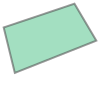

In [42]:
wsg84 = pyproj.Proj(init='epsg:4326')
lambert = pyproj.Proj(init='epsg:31370')
coords = [pyproj.transform(wsg84,lambert,x,y) for (x,y) in dc2.last_draw['geometry']['coordinates'][0]]
polygon2 = shapely.geometry.Polygon(coords)
print(polygon2)
IPython.display.display(polygon2)

In [43]:
b = polygon2.bounds
cropper = {
    "pipeline": list(glob.glob('../data/*150500_166500.las')) + [ # [ '../data/' + lidar_filename,
        {   "type":"filters.crop",
            'bounds':str(([b[0], b[2]],[b[1], b[3]]))},
        {   "type":"filters.merge"},
        {   "type":"filters.hag"},
        {   "type":"filters.crop",
            'polygon':polygon2.wkt},
        {   "type":"filters.eigenvalues",
            "knn":16},
        {   "type":"filters.normal",
            "knn":16}
    ]}
pipeline = pdal.Pipeline(json.dumps(cropper).decode('UTF-8'))
pipeline.validate()
%time n_points = pipeline.execute()
print('Pipeline selected {} points ({:.1f} pts/m2)'.format(n_points, n_points/polygon2.area))

CPU times: user 589 ms, sys: 28.2 ms, total: 617 ms
Wall time: 929 ms
Pipeline selected 5353 points (5.1 pts/m2)


In [44]:
arr = pipeline.arrays[0]
description = arr.dtype.descr
cols = [col for col, __ in description]
df = pd.DataFrame({col: arr[col] for col in cols})
df['X_0'] = df['X']
df['Y_0'] = df['Y']
df['Z_0'] = df['Z']
df['X'] = df['X'] - df['X_0'].mean()
df['Y'] = df['Y'] - df['Y_0'].mean()
df['Z'] = df['Z'] - df['Z_0'].min()
df.loc[df['HeightAboveGround'] < .2,'Classification'] = 2

In [35]:
ground_delaunay = scipy.spatial.Delaunay(df.loc[df['Classification'] != 1, ['X','Y']])

In [36]:
ground = p3.plot_trisurf(df.loc[df['Classification'] != 1,'Y'], df.loc[df['Classification'] != 1,'Z'], df.loc[df['Classification'] != 1,'X'], triangles = ground_delaunay.simplices, color='lightgrey')

In [37]:
non_ground = p3.scatter(df.loc[df['Classification'] == 1,'Y'], df.loc[df['Classification'] == 1,'Z'], df.loc[df['Classification'] == 1,'X'], color='red', size=.2)

ValueError: Can't clean for JSON: array([], dtype=float64)

In [45]:
fig = p3.figure(width=1000)
fig.xlabel='Y'
fig.ylabel='Z'
fig.zlabel='X'
ground_delaunay = scipy.spatial.Delaunay(df.loc[df['Classification'] != 1, ['X','Y']])
ground = p3.plot_trisurf(df.loc[df['Classification'] != 1,'Y'], df.loc[df['Classification'] != 1,'Z'], df.loc[df['Classification'] != 1,'X'], triangles = ground_delaunay.simplices, color='lightgrey')
non_ground = p3.scatter(df.loc[df['Classification'] == 1,'Y'], df.loc[df['Classification'] == 1,'Z'], df.loc[df['Classification'] == 1,'X'], color='red', size=.2)
p3.squarelim()
p3.show()

VBox(children=(Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array('lightgrey', dtype='|S9'), texture=None, triangles=array([[1078,  272,  607],
       [1562, 1561, 1583],
       [ 954, 1078,  607],
       ...,
       [ 906,  905,  935],
       [1301, 1336, 1302],
       [1336, 1337, 1302]], dtype=uint32), x=array([-18.41690454, -17.89690454, -17.90690454, ...,  18.28309546,
        18.29309546,  18.28309546]), y=array([4.36, 4.33, 4.34, ..., 4.03, 4.02, 4.04]), z=array([-16.77862507, -15.55862507, -16.01862507, ...,  15.09137493,
        14.66137493,  14.24137493]))], scatters=[Scatter(color_selected=array('white', dtype='|S5'), size=array(0.2), size_selected=array(2.6), x=array([-14.89690454, -14.87690454, -14.34690454, ...,  16.30309546,
        16.31309546,  17.71309546]), y=array([ 4.88,  4.72,  4.63, ..., 14.4 , 14.3 ,  5.09]), z=array([-12.37862507, -12.78862507, -10.72862507, ...,  11.44137493,
        10.99137493,  14.18137493]))], style={'box': {'visible': True}, 'axes': {'color': 'black', 'visible': True, 'ticklabel': {'color': 'black'}, 'label': {'color': 'black'}}, 'background-color': 'white'}, tf=None, width=1000, xlabel=u'Y', xlim=[-24.811904539499665, 24.688095460500335], ylabel=u'Z', ylim=[-14.375, 35.125], zlabel=u'X', zlim=[-22.768625070049893, 26.731374929950107]),))

In [46]:
roof_mask = (df['Classification'] == 1) & (df['HeightAboveGround'] > 7) & (df['Eigenvalue0'] <= .02) & (df['NumberOfReturns'] == df['ReturnNumber'])

In [47]:
roof_quiver = p3.quiver(df.loc[roof_mask,'Y'],df.loc[roof_mask,'Z'],df.loc[roof_mask,'X'], df.loc[roof_mask,'NormalY'], df.loc[roof_mask,'NormalZ'], df.loc[roof_mask,'NormalX'], size=2)
fig.scatters.append(roof_quiver)
non_ground.visible=False

In [48]:
roof_quiver.x = df.loc[roof_mask,'NormalY'] *15
roof_quiver.y = df.loc[roof_mask,'NormalZ'] *15 + df['Z'].median()
roof_quiver.z = df.loc[roof_mask,'NormalX'] *15

In [49]:
roof_quiver.visible = False
non_ground.visible = True

In [56]:
#Next line doesn't work in python2, unpack
#magnitude = [np.abs(df.loc[roof_mask,['NormalX','NormalY']].values @ np.array([np.cos(alpha), np.sin(alpha)])).sum()
 #            for alpha in alphas]
df.loc[roof_mask,['NormalX','NormalY']]

,NormalX,NormalY
297,0.215683,-0.227220
388,0.310984,-0.469386
393,0.895867,0.444322
438,0.288164,-0.521485
439,0.224233,-0.467168
440,0.237398,-0.461220
441,0.269587,-0.376851
446,-0.899098,-0.434710
491,0.295547,-0.539554
492,0.269176,-0.524817


In [61]:
alphas = np.linspace(0, np.pi, num=180)
np.array([np.cos(alphas[0]),np.sin(alphas[0])])

array([1., 0.])

In [63]:
# Find building orientation using normals
# Note: python3.5 introduced @ for matrix multiplication. Instead I can use einsum and/or work up a small def
def vecprod(A,b):
    return np.einsum('ji,i->j',A,b)

alphas = np.linspace(0, np.pi, num=180)
magnitude = [ np.abs( np.einsum('ji,i->j',df.loc[roof_mask,['NormalX','NormalY']].values,np.array([np.cos(alpha), np.sin(alpha)]))).sum()
             for alpha in alphas]
magnitude2 = [ np.abs( vecprod(df.loc[roof_mask,['NormalX','NormalY']].values,np.array([np.cos(alpha), np.sin(alpha)]))).sum()
             for alpha in alphas]
angle = alphas[np.argmin(magnitude)]
angle2 = alphas[np.argmin(magnitude2)]
angle,angle2

(0.45632072063315426, 0.45632072063315426)

In [64]:
# Rotate building to align walls with X & Y axes
Rotation = np.array([[np.cos(angle), np.sin(angle)],[-np.sin(angle), np.cos(angle)]])
df['X_r'], df['Y_r'] = ( vecprod(df[['X','Y']].values , Rotation[i]) for i in (0,1))
df['NormalX_r'], df['NormalY_r'] = (vecprod(df[['NormalX','NormalY']].values , Rotation[i]) for i in (0,1))
ground.x, ground.z = df.loc[df['Classification']!= 1, 'Y_r'], df.loc[df['Classification']!= 1, 'X_r']
non_ground.x, non_ground.z = df.loc[df['Classification']== 1, 'Y_r'], df.loc[df['Classification']== 1, 'X_r']

In [65]:
# Build 3D model in rotated coordinates
z0 = df.loc[~roof_mask,'Z'].median()
ystep = (df.loc[roof_mask,'Y_r']*4).astype(int)/4
y_profile = (df[roof_mask].groupby(ystep)['Z'].quantile(.99).rolling(window=5).min()).shift(-1).fillna(z0)
xstep = np.linspace(df.loc[roof_mask,'X_r'].quantile(.01), df.loc[roof_mask,'X_r'].quantile(.99), len(ystep.unique()))
X,Y = np.meshgrid(xstep, ystep.sort_values().unique())
Z = y_profile[Y.ravel()].values.reshape(Y.shape)

In [66]:
# Plot 3D model
df_extra = pd.DataFrame({'X_r':X.ravel(),'Y_r':Y.ravel(),'Z': Z.ravel()})
df_extra.loc[df_extra['X_r'] == df_extra['X_r'].max(), 'Z'] = z0
df_extra.loc[df_extra['X_r'] == df_extra['X_r'].min(), 'Z'] = z0
roof_delaunay = scipy.spatial.Delaunay(df_extra[['X_r','Y_r']])
roof_model = p3.plot_trisurf(df_extra['Y_r'],df_extra['Z'],df_extra['X_r'], triangles=roof_delaunay.simplices, color='red')
fig.meshes.append(roof_model)

In [67]:
# Go back to original coordinates
df_extra['X'], df_extra['Y'] = (vecprod(df_extra[['X_r','Y_r']].values , np.linalg.inv(Rotation)[i]) for i in (0,1))
df_extra['Classification'] = 6
ground.x, ground.z = [df.loc[df['Classification']!= 1, axis] for axis in ['Y','X']]
non_ground.visible=False
roof_model.x, roof_model.z = df_extra['Y'], df_extra['X']

In [68]:
# Add texture to the ground
response = requests.get(IVaerial.format(*b))
texture = PIL.Image.open(io.BytesIO(response.content))
ground.u = (df.loc[df['Classification'] != 1, 'X_0'] - b[0]) / (b[2] - b[0])
ground.v = (df.loc[df['Classification'] != 1, 'Y_0'] - b[1]) / (b[3] - b[1])
ground.texture = texture

In [69]:
# ... and to the building
df_extra['X_0'] = df_extra['X'] + df['X_0'].mean()
df_extra['Y_0'] = df_extra['Y'] + df['Y_0'].mean()
roof_model.u = (df_extra['X_0'] - b[0]) / (b[2] - b[0])
roof_model.v = (df_extra['Y_0'] - b[1]) / (b[3] - b[1])
roof_model.texture = texture
p3.style.use('minimal')

# Things to look out for

## pdal
- Fast point-in-polygon algorithm implemented
- Apache arrow support
- Conda packaging

## jupyter
- C++ jupyter kernels 
- Jupyterlab

# Thank you!